In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

In [2]:
from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular

In [74]:

# @torch.jit.script
def evalArea(arg: Union[float, torch.Tensor], packing, dtype, device : torch.device, targetNeighbors : int, kernel, dim = 2):
    
    arg = arg if isinstance(arg, torch.Tensor) else torch.tensor(arg if isinstance(arg, float) or isinstance(arg, int) else 0.0, dtype = dtype, device = device)
    support = volumeToSupport(arg, targetNeighbors, dim)
    
    minDomain = torch.tensor([-1.1 * support] * dim, device = device, dtype = dtype)
    maxDomain = torch.tensor([1.1 * support] * dim, device = device, dtype = dtype)
    
    ii = torch.arange(maxDomain[0] / packing, device = device)
    ii = torch.hstack((ii.flip(0), ii[1:]))
    xx = (ii * packing)
    
    # print('xx', xx.shape)
    
    p = xx.view(-1,1)
    if dim == 2:    
        xx, yy = torch.meshgrid(xx,xx, indexing = 'xy')
        p = torch.stack((xx,yy), dim = -1).flatten(0,1)
    elif dim == 3:
        xx, yy, zz = torch.meshgrid(xx,xx, xx, indexing = 'xy')
        p = torch.stack((xx,yy, zz), dim = -1).flatten(0,2)
    
    rij = torch.linalg.norm(p, dim = -1)
    rij = rij[rij < support]
    k = arg * torch.sum(kernel.kernel(rij / support, torch.ones_like(rij) * support, dim))
    
    return k

    # return ((1 - rho)**2).detach().cpu().numpy()[0]

def optimizeArea(arg: Union[float, torch.Tensor], packing, dtype, device : torch.device, targetNeighbors : int, kernel, dim = 2, thresh = 1e-7, maxIter = 32):
    arg = arg if isinstance(arg, torch.Tensor) else torch.tensor(arg if isinstance(arg, float) or isinstance(arg, int) else 0.0, dtype = dtype, device = device)
    loss = 1
    for i in range(maxIter):
        arg.requires_grad = True
        eval = evalArea(arg, packing, torch.float32, 'cpu', targetNeighbors, kernel, dim)
        loss = (1-eval)**2
        loss.backward()
        arg = (arg - arg * arg.grad / targetNeighbors * 1e-3).detach()
        # print(f'iter: {i}: \tloss: {loss}, arg: {arg}')
        if loss < thresh:
            break
    # print('arg', arg)
    eval = evalArea(arg, packing, torch.float32, 'cpu', targetNeighbors, kernel, dim)
    # print('eval', eval, (1-eval)**2)
    return arg, eval, (1-eval)**2
    # print(eval)

from typing import List
def sampleRegular(
        dx: float = 2/32, dim: int = 2,
        minExtent : float | List[float] = -1, maxExtent : float | List[float] = 1, 
        
        targetNeighbors : int = 50, correctedArea : bool = False, kernel = None):
    minDomain = torch.tensor([minExtent] * dim).to(torch.float32) if isinstance(minExtent, float) or isinstance(minExtent, int) else torch.tensor(minExtent).to(torch.float32)
    maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)
    # dim = minDomain.shape[0]
    # dx = (maxDomain[0] - minDomain[0]) / nx          
    area = dx**(dim)
    # print(area)
    
    if correctedArea:
        area, *_ = optimizeArea(area, dx, torch.float64, 'cpu', targetNeighbors, kernel, dim = dim, thresh = 1e-7**2, maxIter = 64)
    ns = [torch.ceil((maxDomain[i] - minDomain[i]) / dx).to(torch.long) for i in range(dim)]
    lins = [torch.linspace(minDomain[i] + dx / 2, maxDomain[i] - dx/2, ns[i]) for i in range(dim)]
    grid = torch.meshgrid(*lins, indexing = 'xy')
    p = torch.stack(grid, dim = -1).flatten(0,-1).view(-1,dim)

    return p, area

In [3]:
minExtent = -1
maxExtent = 1
nx = 128
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True

from diffSPH.v2.math import volumeToSupport

# 1D Plot

In [4]:
minExtent = -1
maxExtent = 1
nx = 128
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 1
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)
# print(volume, volume, h)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=True, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)
# print(ni)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 

/home/winchenbach/dev/diffSPH/src/diffSPH/v2/sampling.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxDomain = torch.tensor([maxExtent] * dim).to(torch.float32) if isinstance(maxExtent, float) or isinstance(maxExtent, int) else torch.tensor(maxExtent).to(torch.float32)


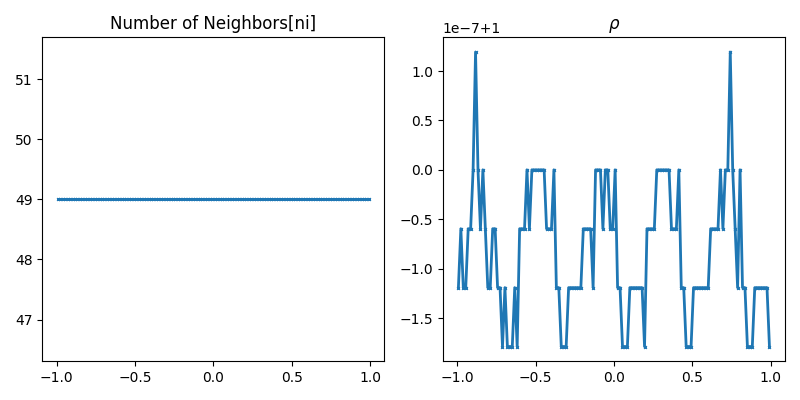

In [5]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.plot(p[:,0], c, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)

scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
# print(rho)

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

# 2D Plot

In [6]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=periodic, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 


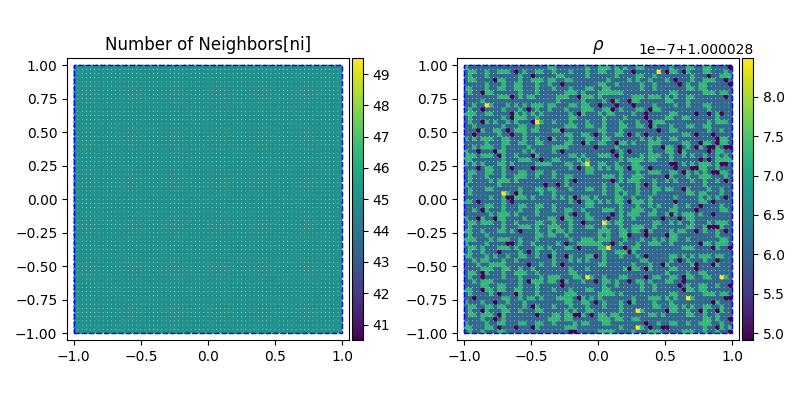

In [7]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.scatter(p[:,0], p[:,1], s = 8, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

# 3D Plot

In [8]:
minExtent = -1
maxExtent = 1
nx = 32
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland4')
periodic = True
dim = 3
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

p, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h

i, j = radiusSearch(p, p, h, periodicity=periodic, domainMin=domainMin, domainMax=domainMax, algorithm ='compact')
ii, ni = countUniqueEntries(i, p)

hij = (supports[i] + supports[j])/2
xij = p[j] - p[i]
if isinstance(periodic, bool):
    periodicity = [periodic] * dim
else:
    periodicity = periodic
xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], domainMin[i], domainMax[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)


rij = torch.linalg.norm(xij, dim = 1)
xij = torch.nn.functional.normalize(xij)
rij = rij / hij
Wij = k.kernel(rij, hij, dim)
gradWij = k.kernelGradient(rij, xij, hij, dim) 

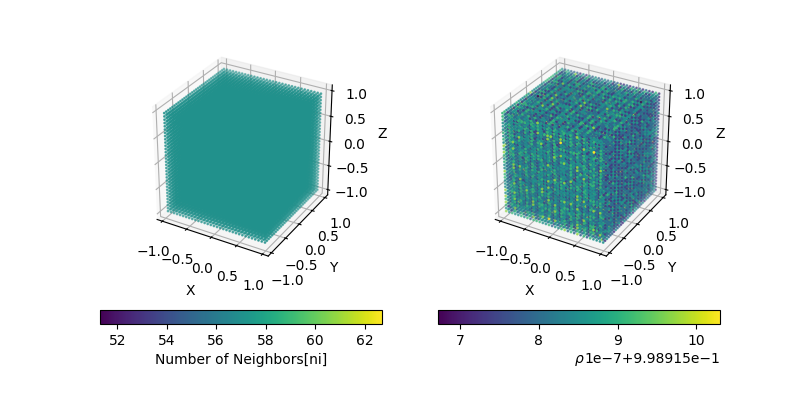

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(p[:, 0], p[:, 1], p[:, 2], s = 1, c = ni)
fig.colorbar(sc, ax=ax, orientation='horizontal', label='Number of Neighbors[ni]', location = 'bottom')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(p[:, 0], p[:, 1], p[:, 2], s = 1, c = rho)
fig.colorbar(sc, ax=ax, orientation='horizontal', label='$\\rho$', location = 'bottom')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')


plt.show()
